## import libraries

In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


#sns.set_palette("husl")
#sns.color_palette("husl", 8)

ModuleNotFoundError: No module named 'sklearn'

## read data and store

In [2]:
df = pd.read_csv("bus.csv")
df

,id,lat,lon,time,acce
0,8,18.404205,-66.046492,9:24:32,0.000000
1,9,18.404124,-66.047754,9:24:57,0.000000
2,10,18.404005,-66.048628,9:25:29,0.000000
3,11,18.403444,-66.049969,9:26:11,0.000000
4,12,18.404178,-66.050321,9:26:41,0.000000
...,...,...,...,...,...
134,142,18.406040,-66.043050,9:26:39,4.818562
135,143,18.406276,-66.042767,9:27:56,0.000000
136,144,18.406932,-66.042834,9:28:50,0.000000
137,145,18.405189,-66.045067,9:31:21,6.632481


## clean and fix data a bit

*Constants*

In [3]:
#seed for random vals
seed = 42
#num of stops
p = 14

*Set stops*

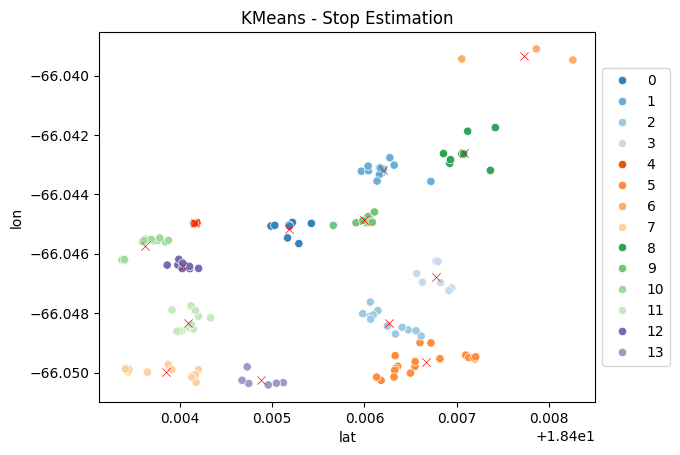

In [4]:
#estimate stops
km = KMeans(n_clusters=p, init='random', n_init=10, max_iter=20, random_state=seed)
loc = df[['lat','lon']]
km.fit(loc)
loc['label'] = km.labels_
sns.scatterplot(data=loc, x='lat', y='lon', hue='label',palette="tab20c")
sns.scatterplot(x=km.cluster_centers_[:, 0], y=km.cluster_centers_[:,1], color='red', marker='x')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("KMeans - Stop Estimation")
plt.show()

In [5]:
#stop labels
#ADJUST THIS BASED ON KMEANS GRAPH
#LAST VALUE IS ALWAYS 15
p0 = [9,11,4,3,19,5,1,13,2,10,20,24,23,6,15]
#attach column and adjust names
df['stop'] = loc['label'].apply( lambda d : p0[d])

In [6]:
### UNUSED

# #spots 8 9 and 10 are too close, estimate better!
# locsub = loc[(loc["label"] > 7) & (loc["label"] < 11)]
# km = KMeans(n_clusters=2, init='random', n_init=200, max_iter=500, random_state=seed)
# km.fit(locsub)
# locsub['label'] = km.labels_
# sns.scatterplot(data=locsub, x='lat', y='lon', hue='label',palette="tab20c")
# sns.scatterplot(x=km.cluster_centers_[:, 0], y=km.cluster_centers_[:,1], color='red', marker='x')
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# plt.title("KMeans - 8,9,10")
# plt.show()

# #there should be two stops between 5 and 0, adjust better!

# locs = loc[(loc["label"] == 5)  | (loc["label"] == 0)]
# km = KMeans(n_clusters=3, init='random', n_init=200, max_iter=500, random_state=seed)
# km.fit(locs)
# locs['label'] = km.labels_
# sns.scatterplot(data=locs, x='lat', y='lon', hue='label',palette="tab20c")
# sns.scatterplot(x=km.cluster_centers_[:, 0], y=km.cluster_centers_[:,1], color='red', marker='x')
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# plt.title("KMeans - 5, 0")
# plt.show()

# #replace values in big labels column
# #removing 10
# x = [8, 9]
# y = locsub['label'].apply( lambda d : x[d])
# for i in y.index.values:
#     loc.iloc[i,loc.columns.get_loc('label')] = y.loc[i]
    
# #add 10 back
# x = [5, 10, 0]
# y = locs['label'].apply( lambda d : x[d])
# for i in y.index.values:
#     loc.iloc[i,loc.columns.get_loc('label')] = y.loc[i]

# #better estimation
# sns.scatterplot(data=loc, x='lat', y='lon', hue='label',palette="tab20c")
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# plt.title("KMeans - Stop Estimation(Adjusted)")
# plt.show()

In [7]:
#drop incorrect data
df_rm = df[df.index < 26]
df = df.drop(df_rm.index, axis=0)
df = df.reset_index()

*Calculate times*

In [8]:
#elapsed time
elapsed = [0]
for i in range(1, len(df["time"])):
    t = pd.to_datetime(df["time"][i],format='%H:%M:%S') - pd.to_datetime(df["time"][i-1],format='%H:%M:%S')
    elapsed.append(t.total_seconds())

df['elapsed'] = elapsed

#add time -> seconds column
ts = df['time'].apply( lambda d : pd.to_datetime(d,format='%H:%M:%S'))
ts = ts.apply( lambda d : d.time() )
sc = ts.apply( lambda d : (d.hour * 60 + d.minute) * 60 + d.second)
df['time_Seconds'] = sc

#df['Time_Seconds'] = df['Time'].total_seconds()
df

,index,id,lat,lon,time,acce,stop,elapsed,time_Seconds
0,26,34,18.403981,-66.046373,8:42:35,0.000000,23,0.0,31355
1,27,35,18.404105,-66.048489,8:43:13,0.000000,24,38.0,31393
2,28,36,18.404201,-66.049903,8:43:56,0.000000,13,43.0,31436
3,29,37,18.405122,-66.050338,8:44:52,4.572018,6,56.0,31492
4,30,38,18.406180,-66.050259,8:45:22,3.924368,5,30.0,31522
...,...,...,...,...,...,...,...,...,...
108,134,142,18.406040,-66.043050,9:26:39,4.818562,11,49.0,33999
109,135,143,18.406276,-66.042767,9:27:56,0.000000,11,77.0,34076
110,136,144,18.406932,-66.042834,9:28:50,0.000000,2,54.0,34130
111,137,145,18.405189,-66.045067,9:31:21,6.632481,9,151.0,34281


*More cleaning*

In [9]:
#remove unnecessary columns
df = df.drop(columns=['id','acce','index'])

In [10]:
#fix more row issues
for index, row in df.iterrows():
    #if first run of stop 2 isnt after stop 1, replace with 15
    #arbitrary number
    if row['stop'] == 2 & df.iloc[index-1]['stop'] != 1:
        df.iloc[index]['stop'] = 15  

#add new empty column
df['round_trip'] = pd.NA

#calculate times between full round stop

for s in p0:
    df_r = df[df['stop'] == s]
    dr = df_r.time_Seconds.diff()
    for i in dr.index.values:
        df.iloc[i,df.columns.get_loc('round_trip')] = dr.loc[i]


#set negative times to NaN
df['elapsed'] = df['elapsed'].mask(df['elapsed'] < 0)
#set round trips that are too short (errors) to NaN
df['round_trip'] = df['round_trip'].mask(df['round_trip'] < 600)

## observe data spread

Correlation between vars
               elapsed  time_Seconds  round_trip
elapsed       1.000000     -0.035258    0.272821
time_Seconds -0.035258      1.000000    0.038512
round_trip    0.272821      0.038512    1.000000


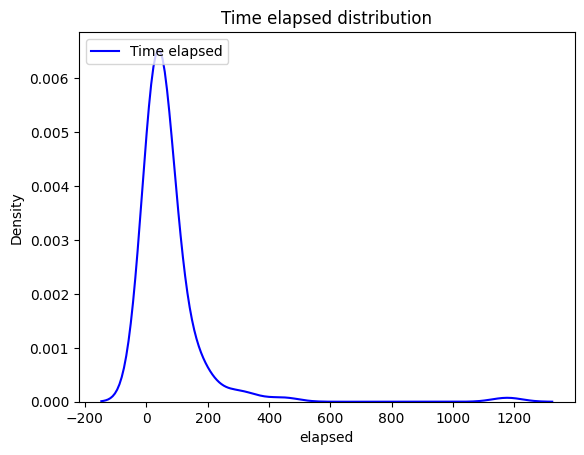

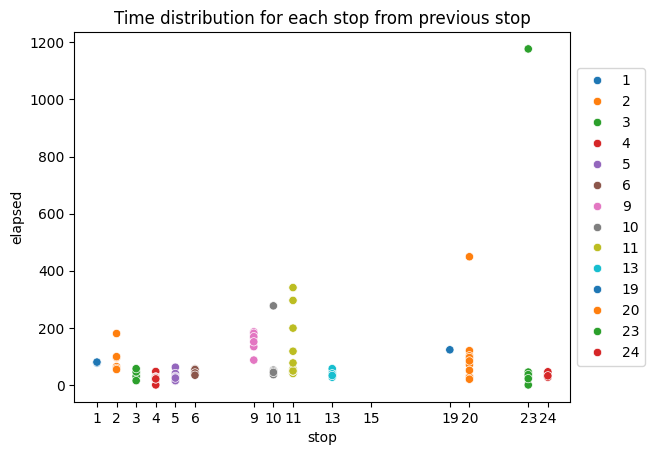

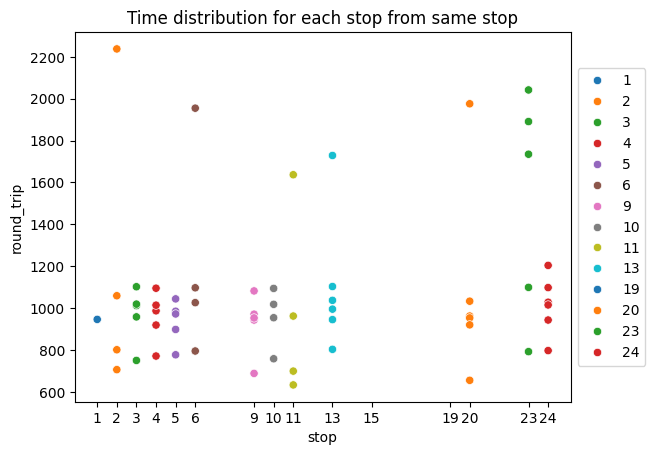

In [11]:
df_c = df[['elapsed', 'time_Seconds', 'round_trip']]
cor = df_c.corr()
print("Correlation between vars")
print(cor)

sns.kdeplot(x=df["elapsed"], color='blue', label="Time elapsed")
plt.legend(loc="upper left")
plt.title("Time elapsed distribution")
plt.show()

ps = pd.Series(p0)

sns.scatterplot(data=df, x='stop', y='elapsed',hue='stop',palette="tab10").set_xticks(ps)
plt.title("Time distribution for each stop from previous stop")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

sns.scatterplot(data=df, x='stop', y='round_trip',hue='stop',palette="tab10").set_xticks(ps)
plt.title("Time distribution for each stop from same stop")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [12]:
print(df.to_string())

df.to_csv('cleaned.csv', index=False)  

           lat        lon     time  stop  elapsed  time_Seconds round_trip
0    18.403981 -66.046373  8:42:35    23      0.0         31355        NaN
1    18.404105 -66.048489  8:43:13    24     38.0         31393        NaN
2    18.404201 -66.049903  8:43:56    13     43.0         31436        NaN
3    18.405122 -66.050338  8:44:52     6     56.0         31492        NaN
4    18.406180 -66.050259  8:45:22     5     30.0         31522        NaN
5    18.407194 -66.049543  8:45:59     5     37.0         31559        NaN
6    18.406721 -66.049000  8:46:16     5     17.0         31576        NaN
7    18.406061 -66.048104  8:46:47     4     31.0         31607        NaN
8    18.406627 -66.046957  8:47:16     3     29.0         31636        NaN
9    18.406023 -66.044951   8:48:3    10     47.0         31683        NaN
10   18.406176 -66.043161  8:48:48    11     45.0         31728        NaN
11   18.407364 -66.043194  8:50:24     2     96.0         31824        NaN
12   18.406322 -66.043016

## Load cleaned_csv, tratar de distribuir más los puntos, plus añadir next stop a cada entrada

In [ ]:
df =  pd.read_csv(')